<a href="https://colab.research.google.com/github/sarahchaudhry02/spam-detection/blob/main/notebook/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spam-detection**

In diesme Projekt werden zwei verschiedene Ansätze der binären Textklassifikation untersucht.
Ziel ist es, E-mail als Spam oder nicht-Spam zu klassifizieren.

Dabei wurden die folgende zwei Ansätze verwendet:

1. Bag-of-Words in Kombination mit einem Naive-Bayes-Klassifikator

2. Kontextuelle Satz-Emebbdings (SentencteTransofmer) in Kombination mit logitischer Regression

Zunächst wurden die Daten aus Kaggle bereinigt und mittels "stratified" in Train-, Validation- und Testset aufgeteilt.

Nach der Anwundung der genannten Methoden wurden folgende Metriken verwendet:

Matthews Correlation Coefficient (MCC)
Precision
Recall
F1- Score
Confusion Matrix

Anschließend werden die Ergebnisse zusammengefasst

#Data Prep

hier werden die daten bereingt, aufgeteilt und ausgegeben.

Die Daten werden wie folgt aufgeteilt:

60% für train
20% für validation
20% für test

Dies stellt sicher, dass genügend Daten zum Trainieren vorhanden sind, wärhend gleichzeitig ausreichend Daten für Validierung und Test zur Verfüfung stehen.

In [ ]:
# Daten aus Kaggle laden
%pip install kagglehub

import os
import kagglehub
import pandas as pd

download_path = kagglehub.dataset_download("gokulraja84/emails-dataset-for-spam-detection")
csv_file_path = os.path.join(download_path, 'Emails.csv')
raw_df = pd.read_csv(csv_file_path)

Using Colab cache for faster access to the 'emails-dataset-for-spam-detection' dataset.


In [ ]:
# doppelte Daten entfernen
raw_unique_df = raw_df.drop_duplicates(subset=['text'], keep='first').copy()
print(f"Größe raw_df: {len(raw_df)} Zeilen")
print(f"Größe raw_unique_df: {len(raw_unique_df)} Zeilen")

Größe raw_df: 5728 Zeilen
Größe raw_unique_df: 5695 Zeilen


In [ ]:
# Konvertierung der label zu 0 und 1
all_df = raw_unique_df.copy()
all_df['label'] = (all_df['spam']).astype(int)
all_df = all_df.drop('spam', axis=1)
display(all_df)

,text,label
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [ ]:
# Aufteilung in train_df und validation_df
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42 # für Reproduzierbarkeit
SHARE_TEST = 0.2

# train- und Testdaten aufteilen
train_full_df, test_df = train_test_split(
    all_df,
    test_size = 0.2, # 20 prozent
    random_state=RANDOM_SEED,
    stratify=all_df['label']
)

# train und validation aus train full aufteilen
train_df, validation_df = train_test_split(
    train_full_df,
    test_size = 0.25, #also 20 prozent, da 25% von 80%
    random_state=RANDOM_SEED,
    stratify=train_full_df['label']
)

# index reset
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


print(f"Größe von train_df: {len(train_df)} Zeilen")
print(f"Größe von validation_df: {len(validation_df)} Zeilen")
print(f"Größe von test_df: {len(test_df)} Zeilen")

Größe von train_df: 3417 Zeilen
Größe von validation_df: 1139 Zeilen
Größe von test_df: 1139 Zeilen


In [ ]:
# Trainingsdaten und Validationdaten ausgeben
print('Trainingsdaten')
display(train_df)
print('Validationdaten')
display(validation_df)

Trainingsdaten


,text,label
0,Subject: guaranteed best mortgage rate the b...,1
1,Subject: over 80 % savings on all best - selli...,1
2,Subject: hi do you want to make $ 1000 or mor...,1
3,Subject: great thanks so much re : avg . month...,0
4,Subject: mid - year 2000 performance feedback ...,0
...,...,...
3412,Subject: charles shen vince : update on charl...,0
3413,Subject: resending paper - - - - - - - - - - ...,0
3414,"Subject: zimin ' s father vince and stinson ,...",0
3415,Subject: do you realize all your sexual dreams...,1


Validationdaten


,text,label
0,"Subject: good morning vince , attached is a ...",0
1,Subject: fluid analysis our customer speak vo...,1
2,Subject: your gateway to wealth profiles + p...,1
3,"Subject: latest revision vince , i have made...",0
4,Subject: re : compound model for reedy creek ...,0
...,...,...
1134,"Subject: re : default rates mark , this is a ...",0
1135,Subject: re : eol competitors - - - - - - - -...,0
1136,Subject: new retail electricity provider surve...,0
1137,Subject: confirmation of your order this is a...,0


**Explorative Datenanalyse (EDA)**

Das folgende Balkendiagramm, zeigt die Verteilung der Klassen (Spam vs. Nicht-Spam)



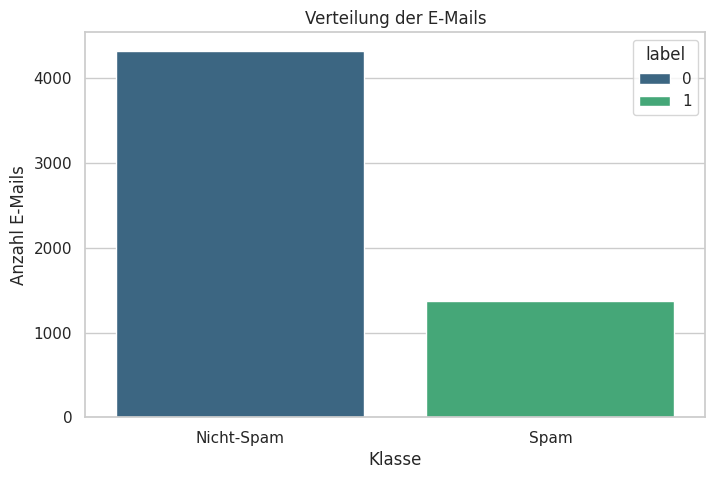

In [ ]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=all_df, hue='label', palette='viridis')

# Balkenbeschriftung
plt.title('Verteilung der E-Mails')
plt.xlabel('Klasse')
plt.ylabel('Anzahl E-Mails')
plt.xticks([0,1],

            ['Nicht-Spam', 'Spam'] )

plt.show()


#Methodische Ansätze

**1. Verfahren: BAG OF WORDS MIT NAIVE BAYERS**


hierbei wurde das nicht-gewichtete Bow verfahren für die Codierung benutzt
daraufhin wurde das Multinomiale Naive Bayes für das Modell benutzt
zum Schluss wurde MCC auf die Train- und Validation Daten angewendet


In [ ]:
# Imports
import sklearn

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Daten vorbereiten
train_df_copy_1 = train_df.copy()
validation_df_copy_1 = validation_df.copy()
test_df_copy_1 = test_df.copy()

train_texts_1 = train_df_copy_1["text"].astype(str)
train_labels_1 = train_df_copy_1["label"].astype(int)

validation_texts_1 = validation_df_copy_1["text"].astype(str)
validation_labels_1 = validation_df_copy_1["label"].astype(int)

test_texts_1 = test_df_copy_1["text"].astype(str)
test_labels_1 = test_df_copy_1["label"].astype(int)

In [ ]:
# token pattern für Bow
# Wörter mit >2 Buchstaben, Zahlen werden rausgelassen
token_pattern_ohne_zahlen = r"(?u)\b[a-zA-Z]{2,}\b"
token_pattern= token_pattern_ohne_zahlen

# vectorizer für bow
vectorizer = CountVectorizer(
lowercase = True,
stop_words = "english",
ngram_range = (1,2),
token_pattern=token_pattern
)

In [ ]:
# test- , validation- und testset mit vectorizer umwandeln
train_text_bow = vectorizer.fit_transform(train_texts_1)
validation_text_bow = vectorizer.transform(validation_texts_1)
test_text_bow = vectorizer.transform(test_texts_1)


In [ ]:
# modell Naive bayers
model_naive_bayes = MultinomialNB(alpha = 1.0)

# modell trainieren
model_naive_bayes.fit(train_text_bow, train_labels_1)

# vorhersagen des Modelles auf Train- und Validaiondaten
prediction_train_text_bow = model_naive_bayes.predict(train_text_bow)
prediction_validation_text_bow = model_naive_bayes.predict(validation_text_bow)
prediction_test_text_bow = model_naive_bayes.predict(test_text_bow)

**2. Verfahren SENTENCE-TRANSFORMER MIT LOGITISCHE REGRESSION**

Die Trainingdaten wurden mit einem vortrainierten SentenceTranformer
in semantische Emnbeddings umgewandet
für die binäre Klassifikation wurde die logitische Regression verwendet, die das One-vs-Rest schema benutzt

In [ ]:

# imports
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


In [ ]:
# Daten vorbereiten
train_df_copy_2 = train_df.copy()
validation_df_copy_2 = validation_df.copy()
test_df_copy_2 = test_df.copy()

# Daten vorbereiten ( SentenceTransformer erwartet Liste)
train_texts_2 = train_df_copy_2["text"].astype(str).tolist()
train_labels_2 = train_df_copy_2["label"].astype(int).values

validation_texts_2 = validation_df_copy_2["text"].astype(str).tolist()
validation_labels_2 = validation_df_copy_2["label"].astype(int).values

test_texts_2 = test_df_copy_2["text"].astype(str).tolist()
test_labels_2 = test_df_copy_2["label"].astype(int).values



In [ ]:
# sentence transofmer Modell erstellen, es wird ein vorgefertigtes Modell benutzt
MODEL_NAME = 'all-MiniLM-L6-v2'
model_sentence_transformer = SentenceTransformer(MODEL_NAME)

# text in semantischen Vektor umwandeln
train_texts_sem = model_sentence_transformer.encode(train_texts_2, show_progress_bar=True)
validation_texts_sem = model_sentence_transformer.encode(validation_texts_2, show_progress_bar=True)
test_texts_sem = model_sentence_transformer.encode(test_texts_2, show_progress_bar=True)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/107 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
# Klaissifikation mit logitische Regression
MAX_ITERATIONS = 1000
classifier = OneVsRestClassifier(LogisticRegression(max_iter=MAX_ITERATIONS))
classifier.fit(train_texts_sem, train_labels_2)

# vorhersagen des Modelles auf Train- und Validaiondaten
prediction_train_text_sem = classifier.predict(train_texts_sem)
prediction_validation_text_sem = classifier.predict(validation_texts_sem)
prediction_test_text_sem = classifier.predict(test_texts_sem)

#Metriken

diese werden benutzt um beide Verfahrne miteinander vergleichen zu können

In [ ]:
# imports

from sklearn.metrics import ( matthews_corrcoef,
                             precision_score,
                              recall_score,
                              f1_score,
                              confusion_matrix,
                              classification_report
                              )

**MCC**

misst wie das Modell zwischen Spam und nicht-Spam unterscheidet, unabhägning von der Klassenverteilung

In [ ]:
# für Verfahren 1
mcc_train_1 = matthews_corrcoef(train_labels_1, prediction_train_text_bow)
mcc_validation_1 = matthews_corrcoef(validation_labels_1, prediction_validation_text_bow)
mcc_test_1 = matthews_corrcoef(test_labels_1, prediction_test_text_bow)

print("1. BAG OF WORDS MIT NAIVE BAYERS")
print(f"Matthew's Correlation Coefficient (MCC) für train: {mcc_train_1:.4f}")
print(f"Matthew's Correlation Coefficient (MCC) für validation: {mcc_validation_1:.4f}")
print(f"Matthew's Correlation Coefficient (MCC) für test: {mcc_test_1:.4f}")

# für Verfahren 2
mcc_train_2 = matthews_corrcoef(train_labels_2, prediction_train_text_sem)
mcc_validation_2 = matthews_corrcoef(validation_labels_2, prediction_validation_text_sem)
mcc_test_2 = matthews_corrcoef(test_labels_2, prediction_test_text_sem)

print("2. Sentence transformer mit logitischer Regression")
print(f"Matthew's Correlation Coefficient (MCC) für train: {mcc_train_2:.4f}")
print(f"Matthew's Correlation Coefficient (MCC) für validation: {mcc_validation_2:.4f}")
print(f"Matthew's Correlation Coefficient (MCC) für test: {mcc_test_2:.4f}")

1. BAG OF WORDS MIT NAIVE BAYERS
Matthew's Correlation Coefficient (MCC) für train: 1.0000
Matthew's Correlation Coefficient (MCC) für validation: 0.9638
Matthew's Correlation Coefficient (MCC) für test: 0.9711
2. Sentence transformer mit logitischer Regression
Matthew's Correlation Coefficient (MCC) für train: 0.9597
Matthew's Correlation Coefficient (MCC) für validation: 0.9588
Matthew's Correlation Coefficient (MCC) für test: 0.9108


**PRECISION**

Damit wird ermittelt, wie viele von den vorhergesgaten Spams auch wirklich Spam ist

In [ ]:
# für Verfahren 1
precision_train_1 = precision_score(train_labels_1, prediction_train_text_bow)
precision_val_1 = precision_score(validation_labels_1, prediction_validation_text_bow)
precision_test_1 = precision_score(test_labels_1, prediction_test_text_bow)

print("1. BAG OF WORDS MIT NAIVE BAYERS")
print(f"Precision für train:{precision_train_1:.4f}")
print(f"Precision für validation:{precision_val_1:.4f}")
print(f"Precision für test:{precision_test_1:.4f}")

# für Verfahren 2
precision_train_2 = precision_score(train_labels_2, prediction_train_text_sem)
precision_val_2 = precision_score(validation_labels_2, prediction_validation_text_sem)
precision_test_2 = precision_score(test_labels_2, prediction_test_text_sem)

print("2. Sentence transformer mit logitischer Regression")
print(f"Precision für train:{precision_train_2:.4f}")
print(f"Precision für validation:{precision_val_2:.4f}")
print(f"Precision für test:{precision_test_2:.4f}")

1. BAG OF WORDS MIT NAIVE BAYERS
Precision für train:1.0000
Precision für validation:1.0000
Precision für test:0.9962
2. Sentence transformer mit logitischer Regression
Precision für train:0.9777
Precision für validation:0.9812
Precision für test:0.9373


**RECALL**

Damit wird ermittelt, wie viele von den echten Spam Nachrichten erkannt wurden

In [ ]:
# für Verfahren 1
recall_train_1 = recall_score(train_labels_1, prediction_train_text_bow)
recall_val_1 = recall_score(validation_labels_1, prediction_validation_text_bow)
recall_test_1 = recall_score(test_labels_1, prediction_test_text_bow)

print("1. BAG OF WORDS MIT NAIVE BAYERS")
print(f"Recall für train:{recall_train_1:.4f}")
print(f"Recall für validation:{recall_val_1:.4f}")
print(f"Recall für test:{recall_test_1:.4f}")

# für Verfahren 2
recall_train_2 = recall_score(train_labels_2, prediction_train_text_sem)
recall_val_2 = recall_score(validation_labels_2, prediction_validation_text_sem)
recall_test_2 = recall_score(test_labels_2, prediction_test_text_sem)

print("2. Sentence transformer mit logitischer Regression")
print(f"Recall für train:{recall_train_2:.4f}")
print(f"Recall für validation:{recall_val_2:.4f}")
print(f"Recall für test:{recall_test_2:.4f}")

1. BAG OF WORDS MIT NAIVE BAYERS
Recall für train:1.0000
Recall für validation:0.9451
Recall für test:0.9599
2. Sentence transformer mit logitischer Regression
Recall für train:0.9610
Recall für validation:0.9560
Recall für test:0.9270


**Confusion Matrix**

zeigt TPs, FPs, TNs, FNs

1. BAG OF WORDS MIT NAIVE BAYERS


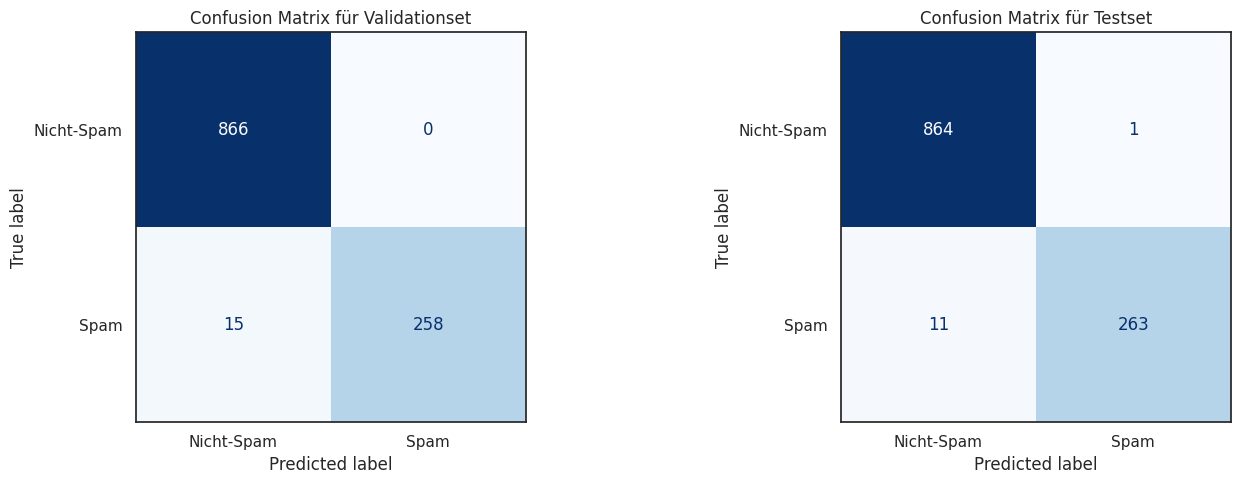

In [ ]:
# Imports
from sklearn.metrics import ConfusionMatrixDisplay

# für Verfahren 1

cm_val_1 = confusion_matrix(validation_labels_1, prediction_validation_text_bow)
cm_test_1 = confusion_matrix(test_labels_1, prediction_test_text_bow)

print("1. BAG OF WORDS MIT NAIVE BAYERS")

sns.set_theme(style="white")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

cm_val_1_show = ConfusionMatrixDisplay(confusion_matrix=cm_val_1, display_labels=['Nicht-Spam', 'Spam'])
cm_val_1_show.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix für Validationset')

cm_test_1_show = ConfusionMatrixDisplay(confusion_matrix=cm_test_1, display_labels=['Nicht-Spam', 'Spam'])
cm_test_1_show.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Confusion Matrix für Testset')

plt.tight_layout()
plt.show()


2. Sentence transformer mit logitischer Regression


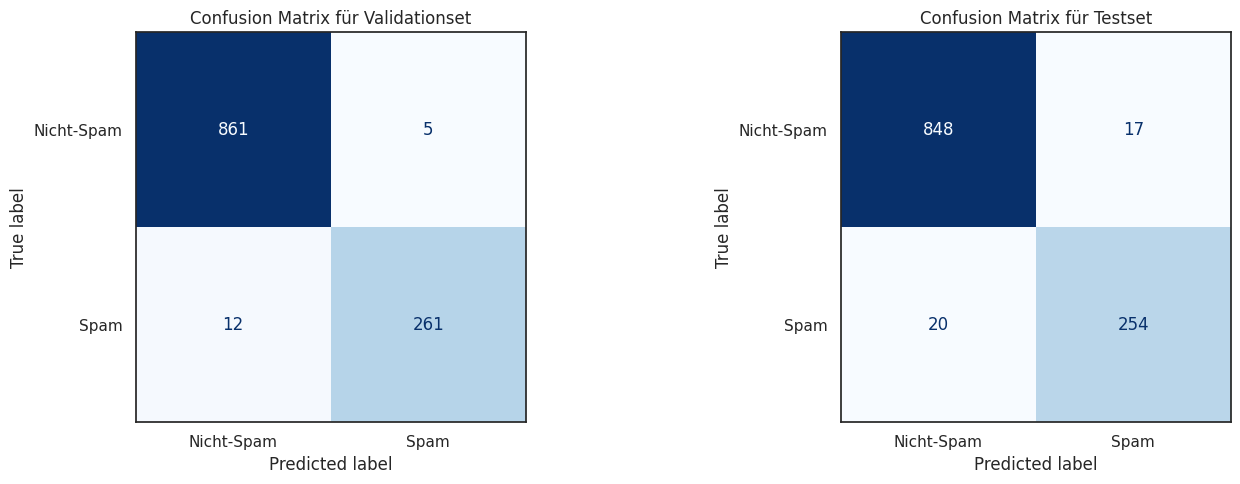

In [ ]:
# für Verfahren 2
cm_val_2 = confusion_matrix(validation_labels_2, prediction_validation_text_sem)
cm_test_2 = confusion_matrix(test_labels_2, prediction_test_text_sem)

print("2. Sentence transformer mit logitischer Regression")

sns.set_theme(style="white")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

cm_val_2_show = ConfusionMatrixDisplay(confusion_matrix=cm_val_2, display_labels=['Nicht-Spam', 'Spam'])
cm_val_2_show.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix für Validationset')

cm_test_2_show = ConfusionMatrixDisplay(confusion_matrix=cm_test_2, display_labels=['Nicht-Spam', 'Spam'])
cm_test_2_show.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Confusion Matrix für Testset')

plt.tight_layout()
plt.show()




#Zusammenfassung

hier werden die Ergebnise der Metriken zusammengefasst



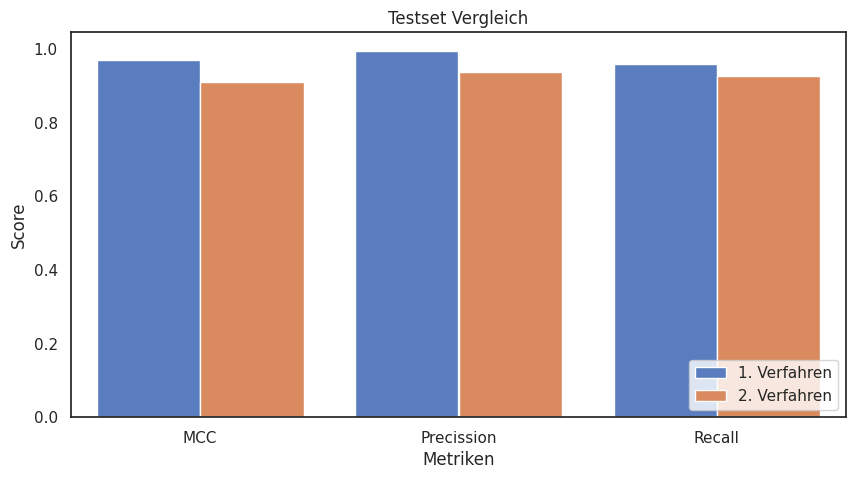

In [ ]:
# Imports
import pandas as pd

daten = {
    'Metriken' : ['MCC', 'Precission', 'Recall'],
    '1. Verfahren' : [mcc_test_1, precision_test_1, recall_test_1],
    '2. Verfahren' : [mcc_test_2, precision_test_2, recall_test_2]
}

df_vergleich = pd.DataFrame(daten)
df_zsm = df_vergleich.melt(id_vars='Metriken', var_name='Modell', value_name='Score')

plt.figure(figsize=(10,5))
sns.barplot(data=df_zsm, x='Metriken', y='Score', hue='Modell', palette='muted')

plt.title('Testset Vergleich')
plt.ylabel('Score')
plt.legend(loc= 'lower right')

plt.show()

**1. Verfahren**

Der MCC-Wert ist auf Train-, Validation- und Testdaten sehr hoch. Precision und Recall weisen ebenfalls hohe Werte auf. Die CM zeigt, dass das Modell nahezu keine Fehlalarme erzeugt und nur wenige Spam-Mails übersieht. Ingesamt klassifiziert das Verfahren sehr zuverlässig.

**2. Verfahren**

Der MCC-Wert liegt unter dem des ersten Verfahrens. Auch Precision und Recall sind etwas niedriger, befinden sich jedoch weiterhin auf einem guten Niveau. Die CM zeigt mehr Fehlalarme sowie mehr übersehene Spam-Mails.
Das Modell funktioniert ingsgesamt gut, ist jedoch schwächer als das erste Verfahren